In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time
import csv
from astropy.io import ascii
import pandas as pd
import pickle

import os
Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline


In [2]:
df_norma_askap = pd.read_pickle('RESULTS/norma_askap.pkl')
df_hydra_askap = pd.read_pickle('RESULTS/hydra_askap.pkl')
df_normaV2_atca = pd.read_pickle('RESULTS/norma_atca_0.2kms.pkl')
df_norma4k_atca = pd.read_pickle('RESULTS/norma_atca_4kms.pkl')
df_hydraV2_atca = pd.read_pickle('RESULTS/hydra_atca_0.2kms.pkl')
df_hydra4k_atca = pd.read_pickle('RESULTS/hydra_atca_4kms.pkl')

## Core code / functions

In [3]:
def keep_highest_amp_per_source(df):
    """
    This function keeps only the row with the highest amplitude ('amp') for each source in the DataFrame.
    
    Parameters:
    df (DataFrame): The input DataFrame containing source data with 'source' and 'amp' columns.
    
    Returns:
    DataFrame: A DataFrame with only one row per source (the one with the highest 'amp').
    """
    # Group by 'source' and get the row with the highest 'amp' for each group
    df_unique = df.loc[df.groupby('source')['amp'].idxmax()]

    
    return df_unique.reset_index(drop=True)


#### 2D plot Code

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS

def plot_continuum_tau(hdulist_hi, ra_deg, dec_deg, tau, title, ra_deg2=None, dec_deg2=None, tau2=None):
    """
    Parameters:
    - hdulist_hi: HDU list from the FITS file.
    - ra_deg, dec_deg, tau: RA, Dec, and tau values for the first set of points (circles).
    - ra_deg2, dec_deg2, tau2: RA, Dec, and tau values for the second set of points (diamonds).
    """
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header

    # Combine tau values if tau2 is provided
    if tau2 is not None:
        combined_tau = np.concatenate([tau, tau2])
    else:
        combined_tau = tau
    
    # Normalize tau values (for a common color scale)
    norm = plt.Normalize(vmin=np.min(combined_tau), vmax=np.max(combined_tau))

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection=WCS(h))
    
    # Display the moment map image
    im = ax.imshow(d, cmap='plasma', vmax=np.percentile(d, 99.9))
    
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # First scatter plot (with circle markers)
    im2 = ax.scatter(ra_deg, dec_deg, transform=ax.get_transform('fk5'), 
                     marker='o', s=150, linewidth=1.5, edgecolor='k', 
                     c=tau, cmap='gray_r', norm=norm, alpha=0.8)
    
    # Second scatter plot (with diamond markers) and lower transparency, if provided
    if ra_deg2 is not None and dec_deg2 is not None and tau2 is not None:
        im3 = ax.scatter(ra_deg2, dec_deg2, transform=ax.get_transform('fk5'), 
                         marker='D', s=35, linewidth=1.5, edgecolor='k', 
                         c=tau2, cmap='gray_r', norm=norm, alpha=0.9)  # More transparent
    
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

    # Add a single colorbar for both scatter plots (based on the normalized tau)
    cbar = plt.colorbar(im2, ax=ax, orientation='vertical', fraction=0.02, pad=0.12)
    cbar.set_label(f'{title}', size=18)
    # Colorbar for the background image (N(HI))
    cbar_hi = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.022, pad=0.15, location='left')
    cbar_hi.set_label('N(HI)', size=18)

    # Overlay with galactic coordinates
    overlay = ax.get_coords_overlay('galactic')
    overlay.grid(color='k', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
    overlay[1].set_axislabel('Galactic Latitude', fontsize=22)
    overlay[0].tick_params(axis='both', which='major', labelsize=18)
    overlay[1].tick_params(axis='both', which='major', labelsize=18)
    
    # Keep the original x/y limits
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    plt.savefig('moment_map_with_galactic.png', dpi=300)
    
    plt.show()

In [5]:
def plot_tau_size_scaled(hdulist_hi, ra_deg, dec_deg, tau, title):
    """
    Plot tau values with the size of the circles proportional to the normalized tau values.

    Parameters:
    - hdulist_hi: HDU list from the FITS file.
    - ra_deg, dec_deg, tau: RA, Dec, and tau values for the points (circles).
    - title: Title for the colorbar (tau scale).
    """
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header

    # Normalize tau values for a common color scale and size scaling
    norm = plt.Normalize(vmin=np.min(np.abs(tau)), vmax=np.max(np.abs(tau)))
    norm2 = plt.Normalize(vmin=np.min(tau), vmax=np.max(tau))
    normalized_tau = abs(norm(tau))

    # Sort indices by normalized tau in descending order
    sorted_indices = np.argsort(-normalized_tau)
    ra_deg_sorted = ra_deg[sorted_indices]
    dec_deg_sorted = dec_deg[sorted_indices]
    tau_sorted = tau[sorted_indices]
    normalized_tau_sorted = normalized_tau[sorted_indices]

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection=WCS(h))

    # Display the moment map image
    im = ax.imshow(d, cmap='plasma', vmax=np.percentile(d, 99.9))
    
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # Scatter plot with size proportional to normalized tau
    im2 = ax.scatter(ra_deg_sorted, dec_deg_sorted, transform=ax.get_transform('fk5'),
                     marker='o', s=abs(normalized_tau_sorted) * 400, linewidth=0.2, edgecolor='k',
                     c=tau_sorted, cmap='gray_r', norm=norm2, alpha=1.)

    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

    # Add a colorbar for the tau values
    cbar = plt.colorbar(im2, ax=ax, orientation='vertical', fraction=0.02, pad=0.12)
    cbar.set_label(f'{title}', size=18)
    
    # Colorbar for the background image (N(HI))
    cbar_hi = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.022, pad=0.15, location='left')
    cbar_hi.set_label('N(HI)', size=18)

    # Overlay with galactic coordinates
    overlay = ax.get_coords_overlay('galactic')
    overlay.grid(color='k', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
    overlay[1].set_axislabel('Galactic Latitude', fontsize=22)
    overlay[0].tick_params(axis='both', which='major', labelsize=18)
    overlay[1].tick_params(axis='both', which='major', labelsize=18)
    
    # Keep the original x/y limits
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    plt.show()


#### 3D plot Code

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from astropy.wcs import WCS

def plot_continuum_tau_3d(hdulist_hi, ra_deg, dec_deg, tau, elev=30, azim=-30):
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    
    # Create a figure with 3D projection
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Set up WCS for 2D projection of the moment map
    wcs_2d = WCS(h)
    x_idx, y_idx = np.meshgrid(np.arange(d.shape[1]), np.arange(d.shape[0]))
    
    # Use the Z plane as 0 for the moment map image
    ax.plot_surface(x_idx, y_idx, np.zeros_like(d), rstride=1, cstride=1, facecolors=plt.cm.plasma(d / np.nanmax(d)), shade=False)

    # Convert RA/Dec to pixel coordinates using WCS
    ra_pix, dec_pix = wcs_2d.wcs_world2pix(ra_deg, dec_deg, 1)
    
    # Plot 3D bars for scatter points, using tau as the height (z-axis)
    ax.bar3d(ra_pix, dec_pix, np.zeros_like(tau), dx=5, dy=5, dz=tau, color=plt.cm.gray_r(tau / np.nanmax(tau)), alpha=0.9)

    # Set axis labels
    ax.set_xlabel('RA', fontsize=14)
    ax.set_ylabel('Dec', fontsize=14)
    ax.set_zlabel(r'$\tau$', fontsize=14)
    
    # Set limits
    ax.set_xlim([0, d.shape[1]])
    ax.set_ylim([0, d.shape[0]])
    
    # Perspective view: adjust the elevation and azimuth for a better 3D view
    ax.view_init(elev=elev, azim=azim)  # Change these values for different perspectives

        # Adjust the spacing between the plot and the colorbars to avoid overlap
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)  # Adjust these values to control the spacing
    
    
    # Add colorbars
    mappable_d = plt.cm.ScalarMappable(cmap='plasma')
    mappable_d.set_array(d)
    fig.colorbar(mappable_d, ax=ax, shrink=0.6, pad=0.15, label='N(HI)')

    mappable_tau = plt.cm.ScalarMappable(cmap='gray_r')
    mappable_tau.set_array(tau)
    fig.colorbar(mappable_tau, ax=ax, location='left', shrink=0.6, label=r'$\tau$')
    
    plt.show()



# ATCA

### Getting the coordinates

In [7]:
df_hydraV2_atca_top = keep_highest_amp_per_source(df_hydraV2_atca)
df_hydra4k_atca_top = keep_highest_amp_per_source(df_hydra4k_atca)

In [8]:
df_normaV2_atca_top = keep_highest_amp_per_source(df_normaV2_atca)
df_norma4k_atca_top = keep_highest_amp_per_source(df_norma4k_atca)

In [9]:
ra_hv2_atca_top =  np.array(df_hydraV2_atca_top['ra (hms)'])
dec_hv2_atca_top =  np.array(df_hydraV2_atca_top['dec (dms)'])
ra_deg_hv2_atca_top  = np.array(df_hydraV2_atca_top['ra (deg)'])
dec_deg_hv2_atca_top  = np.array(df_hydraV2_atca_top['dec (deg)'])

ra_h4k_atca_top  = np.array(df_hydra4k_atca_top['ra (hms)'])
dec_h4k_atca_top  = np.array(df_hydra4k_atca_top['dec (dms)'])
ra_deg_h4k_atca_top  = np.array(df_hydra4k_atca_top['ra (deg)'])
dec_deg_h4k_atca_top  = np.array(df_hydra4k_atca_top['dec (deg)'])

ra_deg_hv2_atca_all  = np.array(df_hydraV2_atca['ra (deg)'])
dec_deg_hv2_atca_all  = np.array(df_hydraV2_atca['dec (deg)'])
ra_deg_h4k_atca_all  = np.array(df_hydra4k_atca['ra (deg)'])
dec_deg_h4k_atca_all  = np.array(df_hydra4k_atca['dec (deg)'])

centre_h = '10:29:00, -27:35:25'
coordinate_h = centre_h.replace(',', '')
c_h = SkyCoord(coordinate_h, unit=(u.hourangle, u.deg))
path_hi_h = SkyView.get_images(position=centre_h, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi_h = path_hi_h[0]


ra_nv2_atca_top  = np.array(df_normaV2_atca_top['ra (hms)'])
dec_nv2_atca_top  = np.array(df_normaV2_atca_top['dec (dms)'])
ra_deg_nv2_atca_top  = np.array(df_normaV2_atca_top['ra (deg)'])
dec_deg_nv2_atca_top  = np.array(df_normaV2_atca_top['dec (deg)'])

ra_n4k_atca_top  = np.array(df_norma4k_atca_top['ra (hms)'])
dec_n4k_atca_top  = np.array(df_norma4k_atca_top['dec (dms)'])
ra_deg_n4k_atca_top  = np.array(df_norma4k_atca_top['ra (deg)'])
dec_deg_n4k_atca_top  = np.array(df_norma4k_atca_top['dec (deg)'])

ra_deg_nv2_atca_all  = np.array(df_normaV2_atca['ra (deg)'])
dec_deg_nv2_atca_all  = np.array(df_normaV2_atca['dec (deg)'])
ra_deg_n4k_atca_all  = np.array(df_norma4k_atca['ra (deg)'])
dec_deg_n4k_atca_all  = np.array(df_norma4k_atca['dec (deg)'])

centre_n = '16:38:00, -59:50:00'
coordinate_n = centre_n.replace(',', '')
c_n = SkyCoord(coordinate_n, unit=(u.hourangle, u.deg))
path_hi_n = SkyView.get_images(position=centre_n, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi_n = path_hi_n[0]


## Hydra

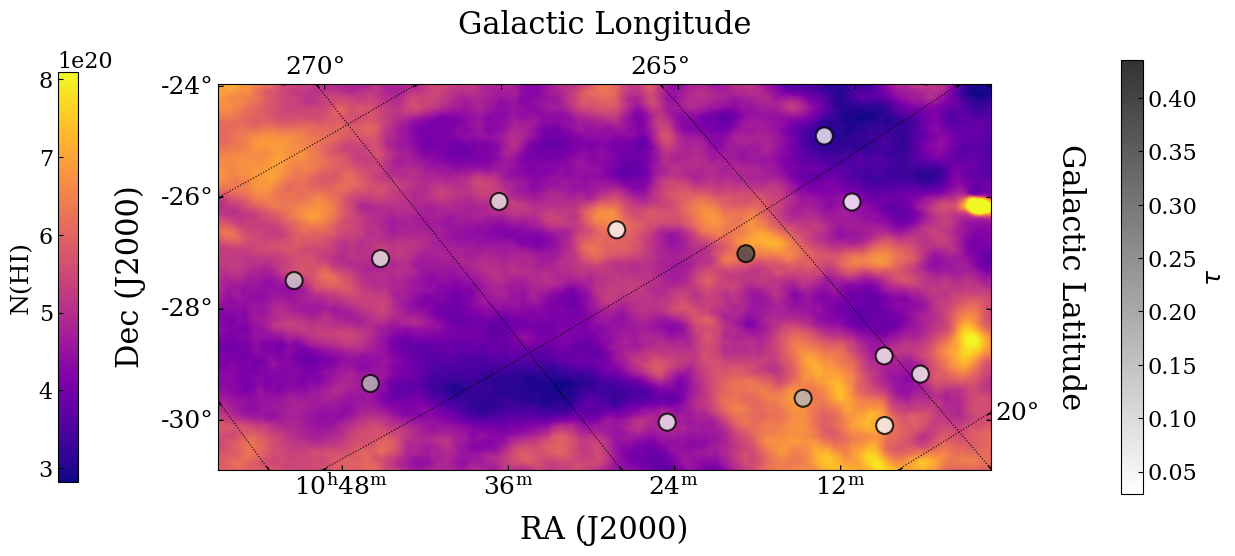

In [16]:
plot_continuum_tau(hdulist_hi_h, ra_deg_h4k_atca_top, dec_deg_h4k_atca_top, df_hydra4k_atca_top['amp'], r"$\tau$")

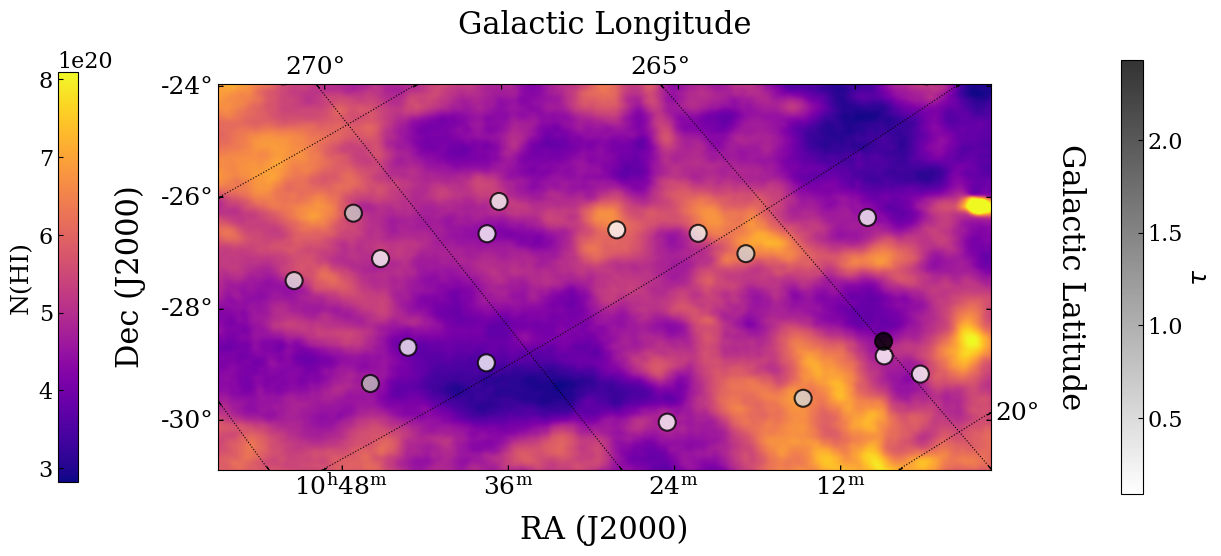

In [11]:
plot_continuum_tau(hdulist_hi_h, ra_deg_hv2_atca_top, dec_deg_hv2_atca_top, df_hydraV2_atca_top['amp'],r"$\tau$")

In [ ]:
plot_tau_size_scaled(hdulist_hi_h, ra_deg_hv2_atca_all, dec_deg_hv2_atca_all, df_hydraV2_atca['amp'],r"$\tau$")

In [ ]:
plot_tau_size_scaled(hdulist_hi_h, ra_deg_h4k_atca_all, dec_deg_h4k_atca_all, df_hydra4k_atca['amp'],r"$\tau$")

In [ ]:
plot_tau_size_scaled(hdulist_hi_h, ra_deg_h4k_atca_all, dec_deg_h4k_atca_all, df_hydra4k_atca['VLSR'],"$km/s$")

In [ ]:
plot_tau_size_scaled(hdulist_hi_h, ra_deg_hv2_atca_all, dec_deg_hv2_atca_all, df_hydraV2_atca['VLSR'],"$km/s$")

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

def plot_continuum_tau_3d(hdulist_hi, ra_deg, dec_deg, tau, elev=30, azim=-30):
    # Extract data and header from the HI FITS file
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    
    # Create a 3D figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Set up WCS for 2D projection of the moment map
    wcs_2d = WCS(h)
    
    # Generate the meshgrid for the data
    ny, nx = d.shape
    x_idx, y_idx = np.meshgrid(np.arange(nx), np.arange(ny))
    
    # Convert the pixel coordinates to RA and Dec using WCS
    ra_map, dec_map = wcs_2d.wcs_pix2world(x_idx, y_idx, 1)
    
    # Adjust the scaling to maintain the rectangular aspect ratio
    aspect_ratio_x = (np.max(ra_map) - np.min(ra_map)) / (np.max(dec_map) - np.min(dec_map))
    
    # Plot the 2D moment map as a surface in the XY plane
    ax.plot_surface(ra_map, dec_map, np.zeros_like(d), rstride=1, cstride=1, facecolors=plt.cm.plasma(d / np.nanmax(d)), shade=False)

    # Convert RA/Dec scatter points to pixel coordinates using WCS
    ra_pix, dec_pix = wcs_2d.wcs_world2pix(ra_deg, dec_deg, 1)
    
    # Plot 3D bars for tau values, scaling the tau as the Z height
    ax.bar3d(ra_deg, dec_deg, np.zeros_like(tau), dx=0.01*aspect_ratio_x, dy=0.01, dz=tau, color=plt.cm.gray_r(tau / np.nanmax(tau)), alpha=0.9)

    # Set axis labels
    ax.set_xlabel('RA (J2000)', fontsize=14)
    ax.set_ylabel('Dec (J2000)', fontsize=14)
    ax.set_zlabel(r'$\tau$', fontsize=14)
    
    # Set the aspect ratio for RA and Dec to maintain the correct shape (rectangle)
    ax.set_box_aspect([aspect_ratio_x, 1, 0.5])  # Adjust Z aspect as needed
    
    # Set limits based on the data
    ax.set_xlim(np.min(ra_map), np.max(ra_map))
    ax.set_ylim(np.min(dec_map), np.max(dec_map))
    
    # Set perspective view: adjust elevation and azimuth
    ax.view_init(elev=elev, azim=azim)
    
    # Adjust the spacing to avoid overlap between the plot and colorbars
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)

    # Add colorbars for both the moment map and tau values
    mappable_d = plt.cm.ScalarMappable(cmap='plasma')
    mappable_d.set_array(d)
    fig.colorbar(mappable_d, ax=ax, shrink=0.6, pad=0.15, label='N(HI)')

    mappable_tau = plt.cm.ScalarMappable(cmap='gray_r')
    mappable_tau.set_array(tau)
    fig.colorbar(mappable_tau, ax=ax, location='left', shrink=0.6, label=r'$\tau$')
    
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import numpy as np

def plot_3d_with_image_overlay(image_path, ra_deg, dec_deg, tau, elev=30, azim=-30):
    # Load the saved 2D plot image with galactic overlay
    img = Image.open(image_path)
    img = np.array(img)
    
    # Create a 3D figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create the 2D surface using the image as texture on the XY plane
    x_idx, y_idx = np.meshgrid(np.linspace(0, img.shape[1], img.shape[1]), np.linspace(0, img.shape[0], img.shape[0]))
    
    # Plot the 2D image as a surface on the XY plane
    ax.plot_surface(x_idx, y_idx, np.zeros_like(x_idx), rstride=1, cstride=1, facecolors=img / 255.0, shade=False)
    
    # Plot 3D bars for tau values
    ax.bar3d(ra_deg, dec_deg, np.zeros_like(tau), dx=0.01, dy=0.01, dz=tau, color=plt.cm.gray_r(tau / np.nanmax(tau)), alpha=0.8)
    
    # Adjust view angle and add labels
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('RA (J2000)')
    ax.set_ylabel('Dec (J2000)')
    ax.set_zlabel(r'$\tau$')

    # Display the plot
    plt.show()

# Example usage:
plot_3d_with_image_overlay('moment_map_with_galactic.png',  ra_deg_h4k_atca_top, dec_deg_h4k_atca_top, df_hydra4k_atca_top['amp'])


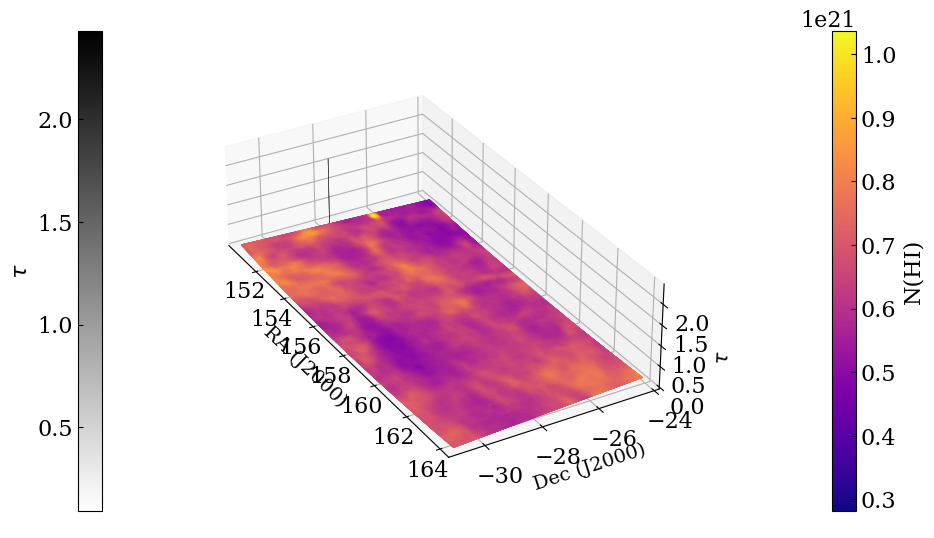

In [14]:
# Tau
plot_continuum_tau_3d(hdulist_hi_h,
                      ra_deg_hv2_atca_top,
                      dec_deg_hv2_atca_top,
                      df_hydraV2_atca_top['amp'])

In [13]:
from mayavi import mlab
from astropy.wcs import WCS
import numpy as np

def plot_continuum_tau_3d(hdulist_hi, ra_deg, dec_deg, tau):
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header

    # WCS setup
    wcs_2d = WCS(h)
    ny, nx = d.shape
    x_idx, y_idx = np.meshgrid(np.arange(nx), np.arange(ny))

    # Convert pixel coordinates to RA/Dec using WCS
    ra_map, dec_map = wcs_2d.wcs_pix2world(x_idx, y_idx, 1)

    # Normalize the moment map for coloring
    d_norm = d / np.nanmax(d)

    # Create the moment map surface in 3D
    mlab.surf(ra_map, dec_map, np.zeros_like(d), scalars=d_norm, colormap='plasma')
    
    # Plot tau values as 3D bars
    mlab.barchart(ra_deg, dec_deg, tau, color=(0.5, 0.5, 0.5))

    # Customize view angle and display
    mlab.view(elevation=30, azimuth=-30)
    mlab.show()

# Example usage:
# plot_continuum_tau_3d_mayavi(hdulist_hi, ra_deg, dec_deg, tau)


ModuleNotFoundError: No module named 'configobj'

In [ ]:
#Velocity
plot_continuum_tau_3d(hdulist_hi_h, 
                      ra_deg_hv2_atca_all, 
                      dec_deg_hv2_atca_all, 
                      df_hydraV2_atca['VLSR'], 
                      elev=50, 
                      azim=-30)

## Norma

In [ ]:
plot_continuum_tau(hdulist_hi_n, ra_deg_nv2_atca, dec_deg_nv2_atca, df_normaV2_atca['amp'], ra_deg_n4k_atca, dec_deg_n4k_atca, df_norma4k_atca['amp'])

In [ ]:
ra_deg_nv2_atca_all  = np.array(df_normaV2_atca['ra (deg)'])
dec_deg_nv2_atca_all  = np.array(df_normaV2_atca['dec (deg)'])

In [ ]:
plot_continuum_tau_3d(hdulist_hi_n, 
                      ra_deg_nv2_atca_all, 
                      dec_deg_nv2_atca_all, 
                      df_normaV2_atca['VLSR'], 
                      elev=50, 
                      azim=-30)

# ASKAP

In [ ]:
# Example usage:
df_hydra_askap_original = df_hydra_askap.copy()
df_hydra_askap = keep_highest_amp_per_source(df_hydra_askap_original)

df_norma_askap_original = df_norma_askap.copy()
df_norma_askap = keep_highest_amp_per_source(df_norma_askap_original)

## Hydra

In [ ]:
ra_h_askap = np.array(df_hydra_askap['ra (hms)'])
dec_h_askap = np.array(df_hydra_askap['dec (dms)'])
ra_deg_h_askap = np.array(df_hydra_askap['ra (deg)'])
dec_deg_h_askap = np.array(df_hydra_askap['dec (deg)'])

#### 2D plot

In [ ]:
plot_continuum_tau(hdulist_hi_h, ra_deg_h_askap, dec_deg_h_askap, df_hydra_askap['amp'])

#### 3D PLOT

In [ ]:
plot_continuum_tau_3d(hdulist_hi_h, ra_deg_h, dec_deg_h, df_hydra['max_amp'])

## Norma

In [ ]:
ra_n_askap = np.array(df_norma_askap['ra (hms)'])
dec_n_askap = np.array(df_norma_askap['dec (dms)'])
ra_deg_n_askap = np.array(df_norma_askap['ra (deg)'])
dec_deg_n_askap = np.array(df_norma_askap['dec (deg)'])


#### 2D 

In [ ]:
plot_continuum_tau(hdulist_hi_n, ra_deg_n_askap, dec_deg_n_askap, df_norma_askap['amp'])

#### 3D

In [ ]:
plot_continuum_tau_3d(hdulist_hi_n, ra_deg_n, dec_deg_n, df_norma['max_amp'], elev=20, azim=-30)